In [1]:
# %pip install pandas pillow
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump

In [3]:

# Функція для отримання унікальних кольорів на зображенні
def get_unique_colors(img):
    colors = img.getcolors(maxcolors=100000) # Збільште maxcolors, якщо зображення має більше кольорів
    color_list = [color[1] for color in colors]
    return color_list

# Шлях до вашого зображення на диску
image_path = '../img/output1small.png'

# Відкриття зображення
img = Image.open(image_path)

# Отримання унікальних кольорів
unique_colors = get_unique_colors(img)

# Створення DataFrame з унікальними кольорами
df_colors = pd.DataFrame(unique_colors, columns=['Red', 'Green', 'Blue', 'Alpha'])

# Виведення таблиці кольорів
df_colors

,Red,Green,Blue,Alpha
0,174,206,144,255
1,243,242,229,255
2,241,240,225,255
3,240,239,225,255
4,240,238,223,255
...,...,...,...,...
541,170,206,146,255
542,143,198,114,255
543,238,231,225,255
544,146,198,115,255


In [4]:
# Функція для визначення, чи є два кольори подібними
def are_similar(color1, color2, threshold=50):
    return np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(color1, color2))) < threshold

# Групування подібних кольорів
grouped_colors = []
for color in unique_colors:
    if not any(are_similar(color, grouped_color, threshold=40) for grouped_color in grouped_colors):
        grouped_colors.append(color)

# Створення DataFrame з групованими кольорами
df_grouped_colors = pd.DataFrame(grouped_colors, columns=['Red', 'Green', 'Blue', 'Alpha'])

# Виведення таблиці групованих кольорів
df_grouped_colors

,Red,Green,Blue,Alpha
0,174,206,144,255
1,243,242,229,255
2,143,198,112,255
3,224,212,193,255
4,179,207,203,255
5,205,188,167,255
6,190,170,131,255
7,236,162,163,255
8,173,143,101,255
9,162,126,57,255


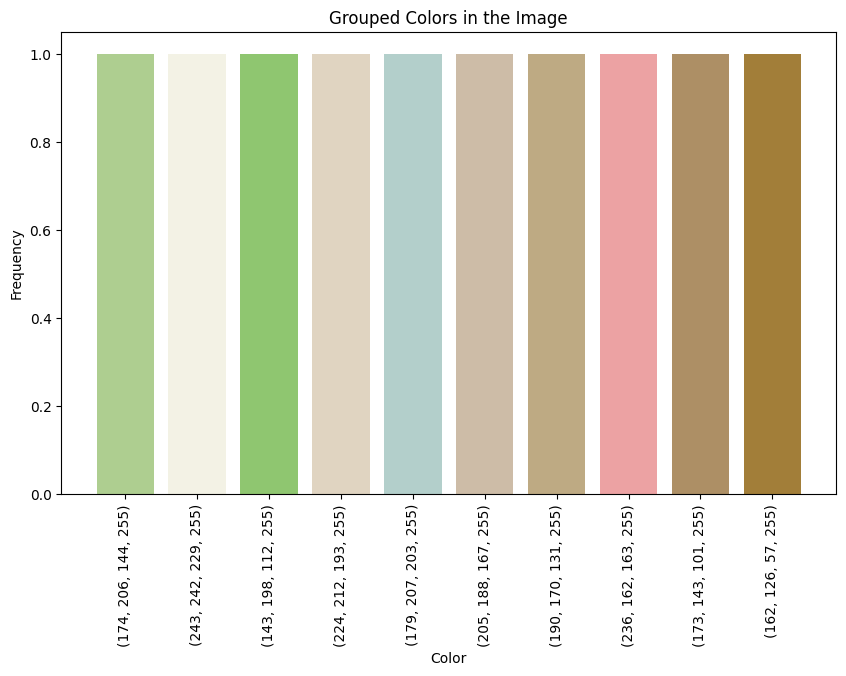

In [5]:
# Створення графіка
plt.figure(figsize=(10, 6))
for i, row in df_grouped_colors.iterrows():
    color = [row['Red'], row['Green'], row['Blue'], row.get('Alpha', 255)] # Додано підтримку альфа-каналу, якщо він існує
    plt.bar(i, 1, color=np.array(color)/255) # Нормалізація кольору для Matplotlib

plt.xticks(range(len(df_grouped_colors)), [f"({row['Red']}, {row['Green']}, {row['Blue']}, {row.get('Alpha', 255)})" for _, row in df_grouped_colors.iterrows()], rotation=90)
plt.title('Grouped Colors in the Image')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.show()


In [6]:
speed_coef = np.array([0.4,0.9,0.3,0.65,0,0.6,0.55,1,0.5,0.45])

df = df_grouped_colors

df['speed_coef']=speed_coef
df

,Red,Green,Blue,Alpha,speed_coef
0,174,206,144,255,0.40
1,243,242,229,255,0.90
2,143,198,112,255,0.30
3,224,212,193,255,0.65
4,179,207,203,255,0.00
5,205,188,167,255,0.60
6,190,170,131,255,0.55
7,236,162,163,255,1.00
8,173,143,101,255,0.50
9,162,126,57,255,0.45


In [7]:

# Підготовка даних
X = df[['Red', 'Green', 'Blue']]  # Особливості (фічі)
y = df['speed_coef']              # Мітки (цільові значення)

# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Створення моделі
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Тренування моделі
model.fit(X_train, y_train)

# Перевірка моделі на тестових даних
y_pred = model.predict(X_test)

# Оцінка моделі
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.011881000000000093


In [8]:
# Передбачення коефіцієнтів швидкості для кожного кольору у df_colors
predicted_speed_coefs = model.predict(df_colors[['Red', 'Green', 'Blue']])

# Додавання передбачених коефіцієнтів до df_colors
df_colors['PredictedSpeedCoef'] = predicted_speed_coefs

# Перегляд результату
df_colors

,Red,Green,Blue,Alpha,PredictedSpeedCoef
0,174,206,144,255,0.3630
1,243,242,229,255,0.7485
2,241,240,225,255,0.7485
3,240,239,225,255,0.7485
4,240,238,223,255,0.7485
...,...,...,...,...,...
541,170,206,146,255,0.3750
542,143,198,114,255,0.3350
543,238,231,225,255,0.7565
544,146,198,115,255,0.3350


In [9]:
dump(model, 'model.joblib')

['model.joblib']

In [10]:
df_colors.describe()

,Red,Green,Blue,Alpha,PredictedSpeedCoef
count,546.000000,546.000000,546.000000,546.0,546.000000
mean,203.989011,196.732601,168.018315,255.0,0.571745
std,28.430954,29.534833,37.221228,0.0,0.153582
min,141.000000,120.000000,46.000000,255.0,0.129000
25%,183.500000,179.250000,142.250000,255.0,0.430000
50%,211.000000,205.000000,173.500000,255.0,0.596000
75%,228.750000,217.000000,199.000000,255.0,0.699000
max,243.000000,242.000000,232.000000,255.0,0.861500
